In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
# Tz
class MonotonicLinear(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size  = input_size
    self.output_size = output_size
    self.weights = torch.nn.Parameter(torch.rand((output_size, input_size), dtype=torch.float32))

  def forward(self, x):
    z = torch.mm(x, torch.exp(self.weights.t()))
    return z

class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1 = MonotonicLinear(1, 3)
    self.input2 = torch.nn.Linear(2, 3)
    self.output = torch.nn.MaxPool1d(3)

  def forward(self, x_m, x_u):
    z1 = self.input1(x_m)
    z2 = self.input2(x_u)
    z = torch.add(z1, z2)
    z = self.output(z)
    return z

Tz = Net()
Tz = torch.load('C:/Users/tln229/Downloads/Python/1. Building/0. Saved models/Tz (1-RNN).pt')

In [3]:
# Read data
df = pd.read_csv('C:/Users/tln229/Downloads/Python/1. Building/data/HVAC_B90_102_exp_10m_20210424.csv')

start = 64
end   = 1600

msa_1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]
Tsa_1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
Tz_0  = np.array(df['room_temp']).reshape(-1,1)[start: end]
Tz_1  = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]

In [4]:
Tz0  =  Tz_0[0].reshape(-1,1)

# horizon length
n = 1536
T = np.array([])
for i in range(n):
    with torch.no_grad():
        # COMPUTE
        x1 = torch.tensor(np.copy(Tsa_1[i]).reshape(-1,1), dtype=torch.float32)
        x2 = np.concatenate((Tz0, msa_1[i].reshape(-1,1)), axis=1)
        x2 = torch.tensor(x2, dtype=torch.float32)
        Tz1 = Tz(x1, x2)

        # UPDATE
        Tz0 = np.copy(Tz1).reshape(-1,1)

        # save Tz
        T = np.append(T, Tz1)

0.7416216222073639
0.8840233005999809


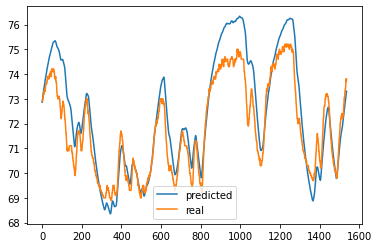

In [5]:
print(r2_score(Tz_1[0:n,0], T))
print(np.mean(np.square(Tz_1[0:n,0] - T)))

plt.plot(T, label='predicted')
plt.plot(Tz_1[0:n, 0], label='real')
plt.legend()
plt.show()